# Introduction

This notebook demonstrates scraping of data from the [Kitchener Utilities](https://www.kitchenerutilities.ca) website and gas & water bills (pdfs).

## Setup instructions:

1. Download the [firefox webdriver](https://github.com/mozilla/geckodriver/releases/) and put it somewhere on your path.

2. Create a new text file called `.env` in this directory to provide your login credentials (i.e., replace `username` and `password`):

```sh
KITCHENER_UTILITIES_USER=username
KITCHENER_UTILITIES_PASSWORD=password
```

In [1]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import os
import sys

sys.path.insert(0, os.path.join("..", "src"))

import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from matplotlib import rcParams

import utility_bill_scraper.kitchener_utilities as ku

load_dotenv()

%matplotlib inline

rcParams.update({"figure.figsize": (12, 6)})

history_path = os.path.abspath(
    os.path.join("..", "data", "Kitchener Utilities", "data.csv")
)

statement_path = os.path.abspath(
    os.path.join("..", "data", "Kitchener Utilities", "statements")
)

history_path = "https://drive.google.com/drive/u/0/folders/13ai3ELMsIrhjFGcv2Lqbwzb4sGkEWK-Y"
statement_path = "https://drive.google.com/drive/u/0/folders/1ANNdGtBWAR6oTalX_h9QxgPjRwlhHQCr"

In [11]:
# Create a Kitchener Utilities API object with your user name and password
username = os.getenv("KITCHENER_UTILITIES_USER")
password = os.getenv("KITCHENER_UTILITIES_PASSWORD")

ku_api = ku.KitchenerUtilitiesAPI(username, password, history_path, statement_path)

updates = ku_api.update()
if updates is not None:
    print(f"{ len(updates) } statements_downloaded")
ku_api.history().tail()

Download file from google drive(file_id=1AMVerD-KArOIZEgdClhIiGOYMsnyadhw, local_path=C:\Users\ryan\AppData\Local\Temp\tmp9hmsgc5u\data.csv
Upload file to google drive folder(folder_id=1ANNdGtBWAR6oTalX_h9QxgPjRwlhHQCr, local_path=C:\Users\ryan\AppData\Local\Temp\tmpcj4t2u9q\2021-09-16 - Kitchener Utilities - $69.90.pdf
Scrape data from C:\Users\ryan\AppData\Local\Temp\tmpcj4t2u9q\2021-09-16 - Kitchener Utilities - $69.90.pdf
Upload file to google drive(file_id=1AMVerD-KArOIZEgdClhIiGOYMsnyadhw, local_path=C:\Users\ryan\AppData\Local\Temp\tmp9hmsgc5u\data.csv
1 statements_downloaded


,Account Number,Balance Forward,Gas & Water Charges,Gas Charges,Gas Consumption,Stormwater Rate Charges,Total Due,Water Charges,Water Consumption
Issue Date,,,,,,,,,
2021-05-14,110159085.0,0.0,87.29,53.33,92.0,16.39,103.68,33.96,6.0
2021-06-15,110159085.0,0.0,68.12,28.51,9.0,16.39,84.51,39.61,7.0
2021-07-16,110159085.0,0.0,61.49,27.53,6.0,16.39,77.88,33.96,6.0
2021-08-17,110159085.0,0.0,56.16,27.87,2.0,16.39,72.55,28.29,5.0
2021-09-16,110159085.0,0.0,53.51,25.22,4.0,16.39,69.90,28.29,5.0


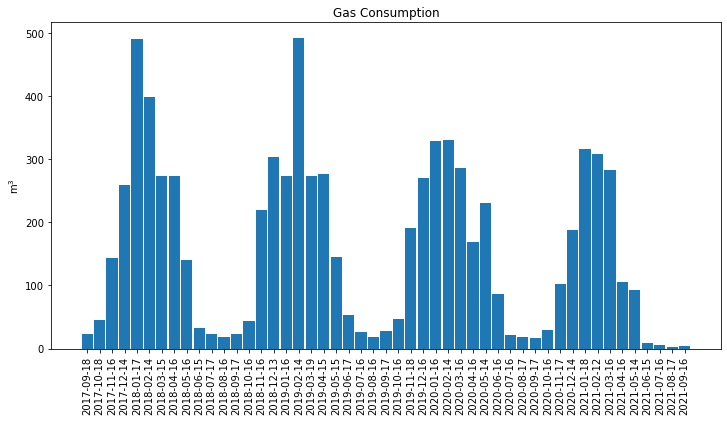

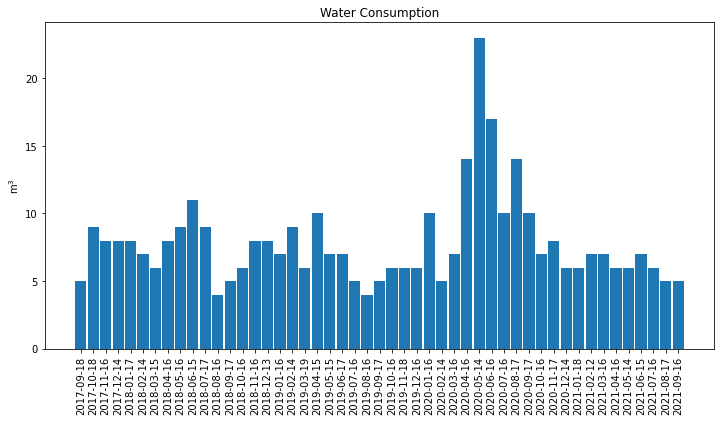

In [13]:
df_ku = ku_api.history()

plt.figure()
plt.bar(df_ku.index, df_ku["Gas Consumption"], width=0.9)
plt.xticks(rotation=90)
plt.title("Gas Consumption")
plt.ylabel("m$^3$")

plt.figure()
plt.bar(df_ku.index, df_ku["Water Consumption"], width=0.9)
plt.xticks(rotation=90)
plt.title("Water Consumption")
plt.ylabel("m$^3$");

In [14]:
# Natural gas emission factor
# 119.58 lbs CO2/1000 cubic feet of natural gas
# 1.915 kg CO2/1 m^3 natural gas [119.58 lbs * (1 kg / 2.204623 lbs) *
#   (1 ft^3 / (0.0254 * 12)**3 m^3) / 1000]
kgCO2_per_cubic_meter = (
    119.58 * (1 / 2.204623) * (1 / (0.0254 * 12) ** 3) / 1000
)  # kg CO2/1 m^3 natural gas

# gas_variable_rate = df_gas['Gas Variable Rate'].iloc[-12:].mean()  # $ / m^3

# Natural gas energy density
# 1,037 Btu / ft^3 (https://www.eia.gov/tools/faqs/faq.php?id=45&t=8)
# Energy per m^3: 1,037 Btu / ft^3 * 1055.1 J / 1 Btu * 1 ft^3 /
#   (0.0254 * 12)**3 m^3
#   37 MJ/m3 (https://hypertextbook.com/facts/2002/JanyTran.shtml)

joules_per_cubic_meter = 1037 * 1055.1 / (0.0254 * 12) ** 3  # J / m^3
kwh_per_joule = 1.0 / (60 * 60 * 1000)
kwh_per_cubic_meter = joules_per_cubic_meter * kwh_per_joule

df_ku["kgCO2"] = df_ku["Gas Consumption"] * kgCO2_per_cubic_meter
df_ku["year"] = [int(x[0:4]) for x in df_ku.index]
df_ku["month"] = [int(x[5:7]) for x in df_ku.index]

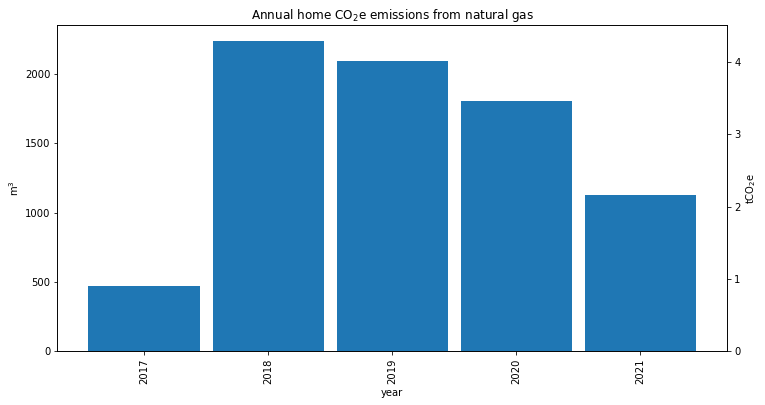

In [15]:
plt.figure()
df_ku.groupby("year").sum()["Gas Consumption"].plot.bar(width=0.9)
plt.ylabel("m$^3$")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([kgCO2_per_cubic_meter * y / 1e3 for y in ylim])
plt.title("Annual home CO$_2$e emissions from natural gas");

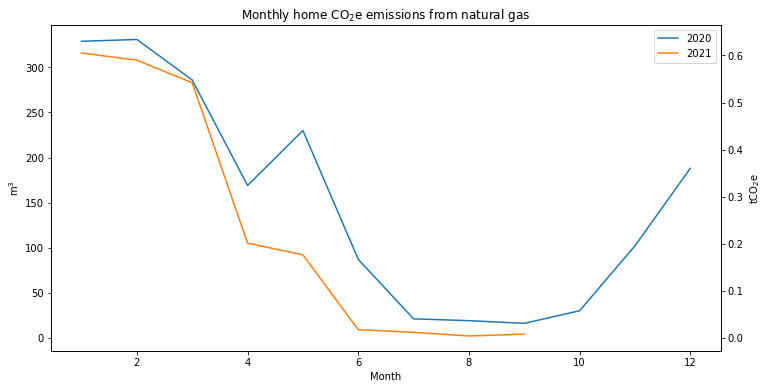

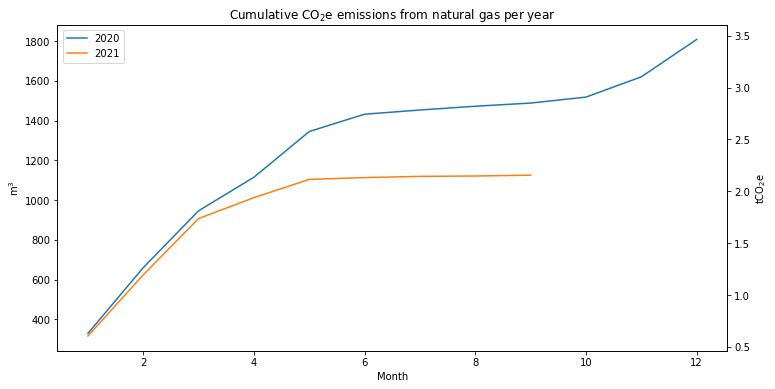

In [16]:
n_years_history = 1

plt.figure()
for year, df_year in df_ku.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month")
        plt.plot(df_year["month"], df_year["Gas Consumption"], label=year)
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([kgCO2_per_cubic_meter * y / 1e3 for y in ylim])
plt.title("Monthly home CO$_2$e emissions from natural gas")

plt.figure()
for year, df_year in df_ku.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month")
        plt.plot(df_year["month"], np.cumsum(df_year["Gas Consumption"]), label=year)
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([kgCO2_per_cubic_meter * y / 1e3 for y in ylim])
plt.title("Cumulative CO$_2$e emissions from natural gas per year");